### Imports

In [1]:
import numpy as np
from utils.balancing import *
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils.analysis import printmd
from constants import PROPENSITY_COLUMNS
from utils.analysis import two_classes_analysis
from sklearn.linear_model import LogisticRegression
from utils.data_science import plot_propensity_graph
from sklearn.ensemble import GradientBoostingClassifier
from utils.data_science import linear_regression_comparison
from constants import DISTINCT_STUDENT_ATTRIBUTES, NUMERICAL_ATTRIBUTES
from utils.ipw import estimate_ate_ipw, calc_bootstap_confidence_interval_ipw

### Loading the Data

In [2]:
pd.set_option('display.max_columns', None)
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

### Raw Columns & data metadata

In [3]:
for c in math_data.columns:
    print(c)

school
sex
age
address
famsize
Pstatus
Medu
Fedu
Mjob
Fjob
reason
guardian
traveltime
studytime
failures
schoolsup
famsup
paid
activities
nursery
higher
internet
romantic
famrel
freetime
goout
Dalc
Walc
health
absences
G1
G2
G3


In [4]:
exist_nulls = math_data.isnull().values.any() | por_data.isnull().values.any()
print(f"Does our data contain null values? Answer: {exist_nulls}")

Does our data contain null values? Answer: False


In [5]:
print("Math class number of students", len(math_data))
print("Portuguese class number of students", len(por_data))

Math class number of students 395
Portuguese class number of students 649


### Creating Treatment and Outcome Columns

In [6]:
# generate our treatment variable
math_data['T'] = ((math_data['Dalc'] * 0.3 + math_data['Walc'] * 0.7) >= 2).astype(int)
por_data['T'] = ((por_data['Dalc'] * 0.3 + por_data['Walc'] * 0.7) >= 2).astype(int)

# generate our outcome variable
math_data['Y'] = (math_data['G1'] + math_data['G2'] + math_data['G3']) / 3
por_data['Y'] = (por_data['G1'] + por_data['G2'] + por_data['G3']) / 3

### Histograms of attributes when divided to two classes are 

C:\Users\Daniel\PyCharm Projects\causal_inference\final_project\utils\analysis.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


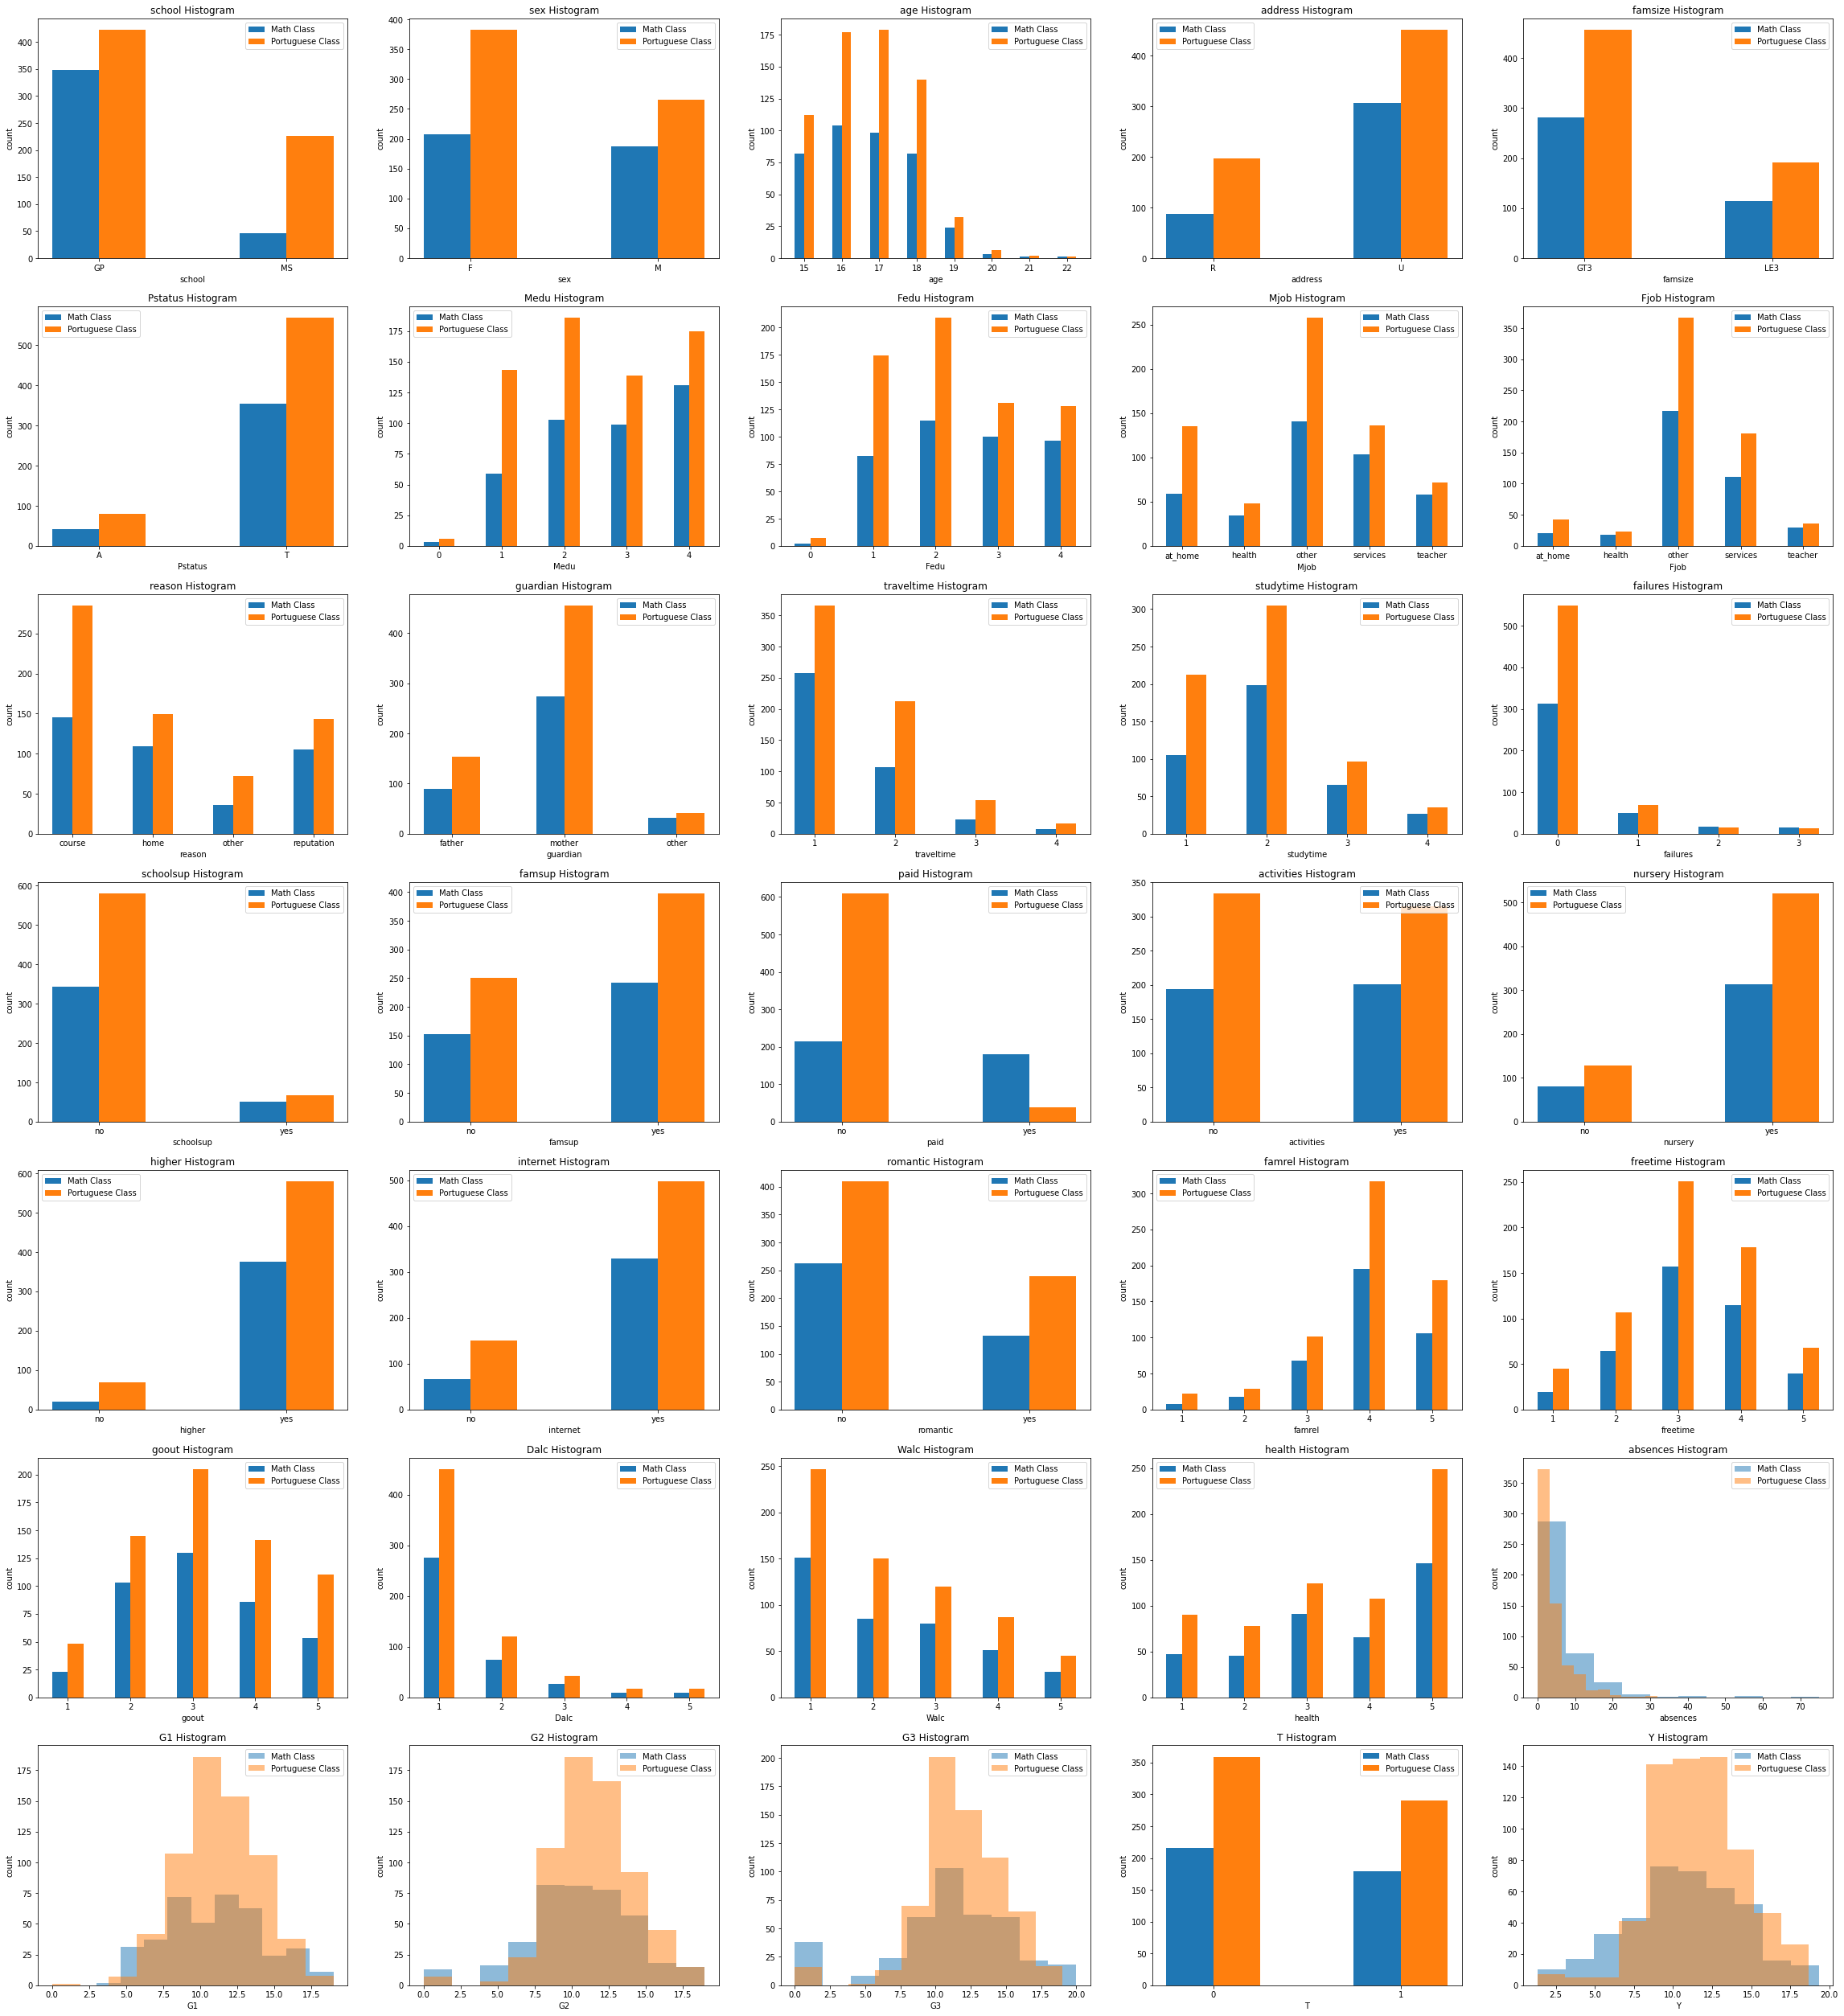

In [7]:
two_classes_analysis(math_data,
                     por_data,
                     NUMERICAL_ATTRIBUTES)

### Liner regression between two classes grades for the dual classes students

intercept [8.10040412]
coef [[0.39314742]]
R^2 0.34131962523689074
R^2_adj 0.8858259158319067


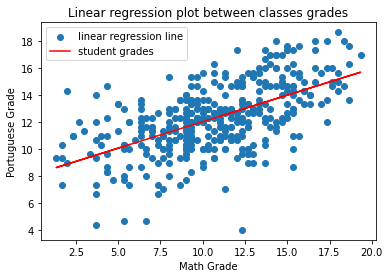

In [8]:
linear_regression_comparison(math_data, por_data)

### Data Cleaning - filtering student older than 21 year-old

In [9]:
math_data = math_data[math_data['age'] < 21]
por_data = por_data[por_data['age'] < 21]

### Reducing dual classes students via sampling 

In [10]:
union_df = pd.concat([math_data, por_data])
cleaned_df = union_df\
    .groupby(DISTINCT_STUDENT_ATTRIBUTES)\
    .sample(n=1, random_state=42).copy()

print("num records in cleaned df:", len(cleaned_df))

num records in cleaned df: 658


In [11]:
# treatment
print("Treatment")
print(cleaned_df['T'].describe()[['count', 'mean']])

# outcome
print("\nOutcome")
print(cleaned_df['Y'].describe()[['mean', 'std']])

Treatment
count    658.000000
mean       0.449848
Name: T, dtype: float64

Outcome
mean    11.067376
std      3.157839
Name: Y, dtype: float64


### Balancing

In [12]:
# students that drink alcohol
treated = cleaned_df[cleaned_df['T'] == 1]
# students that don't drink alcohol
control = cleaned_df[cleaned_df['T'] == 0]

In [13]:
cleaned_df["id"] = range(len(cleaned_df))

In [14]:
original_balance, original_chi = print_balance_table(cleaned_df)
original_balance.to_csv("original_balance.csv")
original_balance

value                     
T                          0             1       
variable                   %    No.      %    No.
school     GP          66.85  242.0  63.85  189.0
           MS          33.15  120.0  36.15  107.0
sex        F           71.82  260.0  43.58  129.0
           M           28.18  102.0  56.42  167.0
address    R           28.73  104.0  32.09   95.0
           U           71.27  258.0  67.91  201.0
famsize    GT3         74.03  268.0  64.53  191.0
           LE3         25.97   94.0  35.47  105.0
Pstatus    A           14.64   53.0  10.14   30.0
           T           85.36  309.0  89.86  266.0
Mjob       at_home     22.10   80.0  20.27   60.0
           health       7.18   26.0   7.43   22.0
           other       40.61  147.0  37.16  110.0
           services    19.61   71.0  24.32   72.0
           teacher     10.50   38.0  10.81   32.0
Fjob       at_home      7.73   28.0   6.08   18.0
           health       4.97   18.0   2.03    6.0
           other       56.08  203.0  56.42  167.0
           services    24.59   89.0  31.76   94.0
           teacher      6.63   24.0   3.72   11.0
reason     course      44.48  161.0  42.23  125.0
           home        21.82   79.0  24.32   72.0
           other        9.39   34.0  13.18   39.0
           reputation  24.31   88.0  20.27   60.0
guardian   father      21.55   78.0  24.66   73.0
           mother      70.99  257.0  66.22  196.0
           other        7.46   27.0   9.12   27.0
schoolsup  no          88.12  319.0  90.88  269.0
           yes         11.88   43.0   9.12   27.0
famsup     no          36.74  133.0  42.23  125.0
           yes         63.26  229.0  57.77  171.0
paid       no          82.60  299.0  78.72  233.0
           yes         17.40   63.0  21.28   63.0
activities no          53.87  195.0  50.00  148.0
           yes         46.13  167.0  50.00  148.0
nursery    no          18.23   66.0  23.31   69.0
           yes         81.77  296.0  76.69  227.0
higher     no           8.01   29.0  13.85   41.0
           yes         91.99  333.0  86.15  255.0
internet   no          25.69   93.0  21.62   64.0
           yes         74.31  269.0  78.38  232.0
romantic   no          61.88  224.0  62.84  186.0
           yes         38.12  138.0  37.16  110.0

In [15]:
original_chi.to_csv("original_chi.csv")
original_chi

,,Chi Square,p value
school,school,0.52,0.47
sex,sex,52.58,<0.05
address,address,0.72,0.396
famsize,famsize,6.53,<0.05
Pstatus,Pstatus,2.60,0.107
Mjob,Mjob,2.44,0.655
Fjob,Fjob,10.12,<0.05
reason,reason,3.92,0.271
guardian,guardian,1.78,0.411
schoolsup,schoolsup,1.03,0.311


# Methods

### help functions

In [16]:
res_dict = {}

## Naive ATE calculation

In [17]:
cleaned_df = cleaned_df.reset_index()

In [18]:
Y1 = np.array(cleaned_df[cleaned_df['T'] == 1]['Y']).mean()
Y0 = np.array(cleaned_df[cleaned_df['T'] == 0]['Y']).mean()
delta_all = Y1 - Y0
printmd(f"$\hat (ATE) $={round(delta_all, 3)}")

$\hat (ATE) $=-0.962

In [19]:
deltas = []
B = 400
alpha = 0.05
for i in range(B):
    temp_sample = cleaned_df.sample(n=200, replace=True)  # allow selecting each row more than once
    # fitting the linear model
    temp_mu1 = np.array(temp_sample[temp_sample['T'] == 1]['Y']).mean()
    temp_mu0 = np.array(temp_sample[temp_sample['T'] == 0]['Y']).mean()
    deltas.append(temp_mu1 - temp_mu0)

deltas.sort()
CI_0 = [deltas[int(B * (alpha / 2))], deltas[int(B * (1 - alpha / 2))]]
printmd("**The CI for delta is:**")
print(CI_0)

**The CI for delta is:**

[-1.8365667254556097, -0.12062624422174828]


In [20]:
res_dict['Naive ATE'] = [delta_all, CI_0]

### Calculating Propensity

In [21]:
df_propensity = cleaned_df[PROPENSITY_COLUMNS]
treatment = cleaned_df["T"]

# Creating dummy variables
df_propensity = pd.get_dummies(df_propensity)

### Scaling the Data

In [22]:
scaler = preprocessing.StandardScaler().fit(df_propensity)
df_propensity_scaled = scaler.transform(df_propensity)

### Logistic Regression

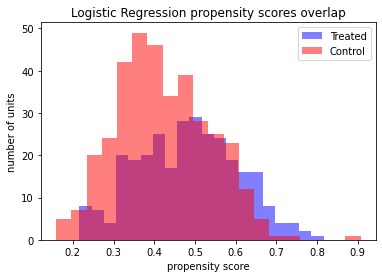

In [23]:
logistic_clf = LogisticRegression(random_state=0).fit(df_propensity_scaled, treatment)
logistic_propensity = logistic_clf.predict_proba(df_propensity_scaled)[:, 1]
plot_propensity_graph("Logistic Regression", treatment, logistic_propensity)
plt.savefig("LogisticRegression_propensity_score_overlap.png")

### Gradient Boosted Trees

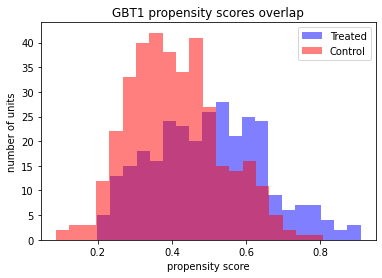

In [24]:
trees_clf = GradientBoostingClassifier(n_estimators=100,
                                       learning_rate=1.0,
                                       max_depth=1,
                                       random_state=0).fit(df_propensity_scaled, treatment)
trees_propensity = trees_clf.predict_proba(df_propensity_scaled)[:, 1]
plot_propensity_graph("GBT1", treatment, trees_propensity)
plt.savefig("GBT1_propensity_score_overlap.png")

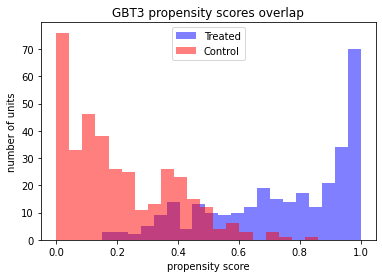

In [25]:
trees_clf_3 = GradientBoostingClassifier(n_estimators=100,
                                         learning_rate=1.0,
                                         max_depth=3,
                                         random_state=0).fit(df_propensity_scaled, treatment)
trees_propensity_3 = trees_clf_3.predict_proba(df_propensity_scaled)[:, 1]
plot_propensity_graph("GBT3", treatment, trees_propensity_3)
plt.savefig("GBT3_propensity_score_overlap.png")

Logistic Regression:
	Brier: 0.232
Gradient Boosted Trees 1:
	Brier: 0.223
Gradient Boosted Trees 3:
	Brier: 0.092


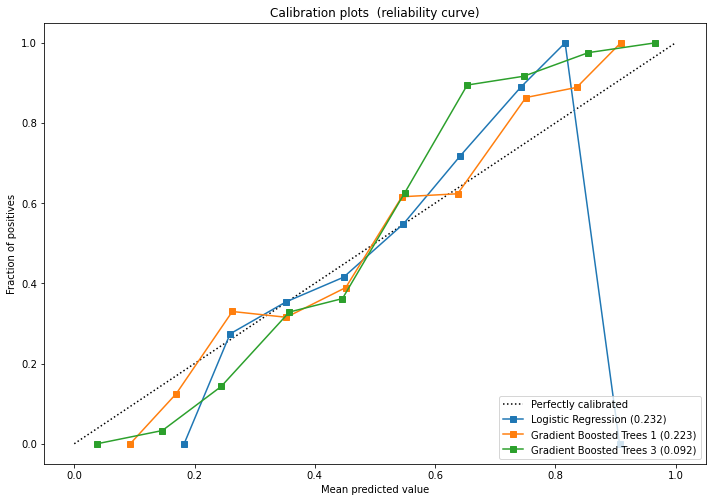

In [26]:
from utils.data_science import plot_calibration_curve

est_dict = {'Logistic Regression': logistic_propensity,
            'Gradient Boosted Trees 1': trees_propensity,
            'Gradient Boosted Trees 3': trees_propensity_3}

plot_calibration_curve(est_dict, treatment)
plt.savefig("calibration_plots.png")
plt.show()

### LR balance

In [27]:
LR_balance, LR_chi = print_balance_table_est(cleaned_df, logistic_propensity)
LR_balance

T                             0         1
school     GP          0.657324  0.618567
           MS          0.342676  0.381433
sex        F           0.701159  0.402586
           M           0.298841  0.597414
address    R           0.289993  0.329213
           U           0.710007  0.670787
famsize    GT3         0.738355  0.648740
           LE3         0.261645  0.351260
Pstatus    A           0.154956  0.096665
           T           0.845044  0.903335
Mjob       at_home     0.215468  0.203547
           health      0.071729  0.070980
           other       0.410090  0.370472
           services    0.198776  0.247835
           teacher     0.103937  0.107166
Fjob       at_home     0.080806  0.060092
           health      0.046967  0.019509
           other       0.562064  0.572788
           services    0.245516  0.311957
           teacher     0.064647  0.035654
reason     course      0.449666  0.442095
           home        0.220033  0.236861
           other       0.096860  0.135314
           reputation  0.233441  0.185730
guardian   father      0.198125  0.249725
           mother      0.718462  0.651808
           other       0.083412  0.098467
schoolsup  no          0.899144  0.919031
           yes         0.100856  0.080969
famsup     no          0.391848  0.454687
           yes         0.608152  0.545313
paid       no          0.833305  0.787906
           yes         0.166695  0.212094
activities no          0.522806  0.475820
           yes         0.477194  0.524180
nursery    no          0.190450  0.232589
           yes         0.809550  0.767411
higher     no          0.104524  0.174715
           yes         0.895476  0.825285
internet   no          0.236568  0.194682
           yes         0.763432  0.805318
romantic   no          0.598757  0.630614
           yes         0.401243  0.369386

In [28]:
LR_chi

,,Chi Square,p value
school,school,0.00,1.000
sex,sex,0.00,1.000
address,address,0.00,1.000
famsize,famsize,0.00,1.000
Pstatus,Pstatus,0.00,1.000
Mjob,Mjob,0.01,1.000
Fjob,Fjob,0.03,1.000
reason,reason,0.01,1.000
guardian,guardian,0.01,0.995
schoolsup,schoolsup,0.00,1.000


In [29]:
GBT1_balance, GBT1_chi = print_balance_table_est(cleaned_df, trees_propensity)
GBT1_balance

T                             0         1
school     GP          0.659168  0.623298
           MS          0.340832  0.376702
sex        F           0.699549  0.401522
           M           0.300451  0.598478
address    R           0.282894  0.328342
           U           0.717106  0.671658
famsize    GT3         0.735757  0.645859
           LE3         0.264243  0.354141
Pstatus    A           0.152966  0.099907
           T           0.847034  0.900093
Mjob       at_home     0.215225  0.200133
           health      0.072768  0.067899
           other       0.407837  0.372418
           services    0.203119  0.254578
           teacher     0.101052  0.104972
Fjob       at_home     0.080119  0.060938
           health      0.050013  0.020872
           other       0.568914  0.571825
           services    0.236017  0.309291
           teacher     0.064938  0.037075
reason     course      0.457811  0.435016
           home        0.217364  0.244324
           other       0.097776  0.131431
           reputation  0.227049  0.189230
guardian   father      0.195315  0.250643
           mother      0.724889  0.652249
           other       0.079796  0.097108
schoolsup  no          0.895247  0.920908
           yes         0.104753  0.079092
famsup     no          0.386785  0.454656
           yes         0.613215  0.545344
paid       no          0.832355  0.780087
           yes         0.167645  0.219913
activities no          0.512955  0.482475
           yes         0.487045  0.517525
nursery    no          0.192422  0.230385
           yes         0.807578  0.769615
higher     no          0.105075  0.172183
           yes         0.894925  0.827817
internet   no          0.241689  0.192511
           yes         0.758311  0.807489
romantic   no          0.604775  0.628197
           yes         0.395225  0.371803

In [30]:
GBT1_chi

,,Chi Square,p value
school,school,0.00,1.000
sex,sex,0.00,1.000
address,address,0.00,1.000
famsize,famsize,0.00,1.000
Pstatus,Pstatus,0.00,1.000
Mjob,Mjob,0.01,1.000
Fjob,Fjob,0.03,1.000
reason,reason,0.01,1.000
guardian,guardian,0.01,0.994
schoolsup,schoolsup,0.00,1.000


In [31]:
GBT3_balance, GBT3_chi = print_balance_table_est(cleaned_df, trees_propensity_3)
GBT3_balance

T                             0         1
school     GP          0.699265  0.619013
           MS          0.300735  0.380987
sex        F           0.661647  0.422826
           M           0.338353  0.577174
address    R           0.270474  0.329292
           U           0.729526  0.670708
famsize    GT3         0.733574  0.647963
           LE3         0.266426  0.352037
Pstatus    A           0.133171  0.101920
           T           0.866829  0.898080
Mjob       at_home     0.186336  0.210744
           health      0.071835  0.060813
           other       0.449372  0.376861
           services    0.179560  0.254647
           teacher     0.112898  0.096935
Fjob       at_home     0.063261  0.067412
           health      0.050803  0.019790
           other       0.590956  0.558184
           services    0.228498  0.315964
           teacher     0.066482  0.038649
reason     course      0.443620  0.431096
           home        0.224697  0.232278
           other       0.119489  0.139032
           reputation  0.212194  0.197594
guardian   father      0.214095  0.251274
           mother      0.731706  0.648423
           other       0.054199  0.100304
schoolsup  no          0.933845  0.899994
           yes         0.066155  0.100006
famsup     no          0.372633  0.439068
           yes         0.627367  0.560932
paid       no          0.811727  0.786547
           yes         0.188273  0.213453
activities no          0.505564  0.499337
           yes         0.494436  0.500663
nursery    no          0.154726  0.231375
           yes         0.845274  0.768625
higher     no          0.059625  0.164504
           yes         0.940375  0.835496
internet   no          0.212991  0.215470
           yes         0.787009  0.784530
romantic   no          0.623846  0.629232
           yes         0.376154  0.370768

In [32]:
GBT3_chi

,,Chi Square,p value
school,school,0.00,1.000
sex,sex,0.00,1.000
address,address,0.00,1.000
famsize,famsize,0.00,1.000
Pstatus,Pstatus,0.00,1.000
Mjob,Mjob,0.02,1.000
Fjob,Fjob,0.04,1.000
reason,reason,0.00,1.000
guardian,guardian,0.02,0.989
schoolsup,schoolsup,0.00,1.000


### Estimating with IPW

In [33]:
Y = cleaned_df["Y"]

In [34]:
print("LR:")
LR_ATE_IPW = estimate_ate_ipw(treatment, Y, logistic_propensity)
print(LR_ATE_IPW)
CI_LR_ATE_IPW = calc_bootstap_confidence_interval_ipw(cleaned_df, logistic_propensity)
res_dict['Logistic Regression IPW'] = [LR_ATE_IPW, CI_LR_ATE_IPW]

LR:
-0.5118950154234472


**The CI for delta is:**

[-3.608427842863409, 3.334818519818209]


In [35]:
print("GBT:")
estimate_ate_ipw(treatment, Y, trees_propensity)
GBT_ATE_IPW = estimate_ate_ipw(treatment, Y, trees_propensity)
print(GBT_ATE_IPW)
CI_GBT_ATE_IPW = calc_bootstap_confidence_interval_ipw(cleaned_df, trees_propensity)
res_dict['Gradient Boosted trees 1 IPW'] = [GBT_ATE_IPW, CI_GBT_ATE_IPW]

GBT:
-0.3921226665670253


**The CI for delta is:**

[-3.296499952350908, 3.1176575000131357]


In [36]:
print("GBT3:")
estimate_ate_ipw(treatment, Y, trees_propensity_3)
GBT3_ATE_IPW = estimate_ate_ipw(treatment, Y, trees_propensity_3)
print(GBT3_ATE_IPW)
CI_GBT3_ATE_IPW = calc_bootstap_confidence_interval_ipw(cleaned_df, trees_propensity_3)
res_dict['Gradient Boosted trees 3 IPW'] = [GBT3_ATE_IPW, CI_GBT3_ATE_IPW]

GBT3:
-1.0528337308770255


**The CI for delta is:**

[-3.7265638775875822, 1.4862880180634102]


In [37]:
from utils.matching import matching, matching_to_dataframe

In [38]:
logistic_propensity_sr = pd.Series(logistic_propensity).rename("propensity", inplace=True)
df_LR = cleaned_df.join(logistic_propensity_sr)

In [39]:
matches_LR = matching(label=treatment,
                      propensity=logistic_propensity_sr,
                      calipher=0.1,
                      replace=True)

T
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

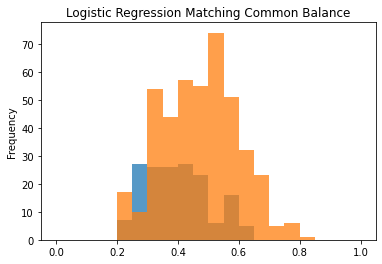

In [40]:
matches_data_frame_LR = matching_to_dataframe(match=matches_LR,
                                              covariates=df_LR,
                                              remove_duplicates=False)

matches_data_frame_LR.groupby("T")["propensity"].plot(kind="hist",
                                                      sharex=True,
                                                      range=(0, 1),
                                                      bins=20,
                                                      alpha=0.75,
                                                      title="Logistic Regression Matching Common Balance")

In [41]:
LR_balance_table, LR_balance_chi = print_balance_table(matches_data_frame_LR)
LR_balance_table

value                     
T                           0             1       
variable                    %    No.      %    No.
school     GP          100.00  163.0  75.06  322.0
           MS             NaN    NaN  24.94  107.0
sex        F            73.62  120.0  47.79  205.0
           M            26.38   43.0  52.21  224.0
address    R            20.86   34.0  33.57  144.0
           U            79.14  129.0  66.43  285.0
famsize    GT3          85.28  139.0  68.07  292.0
           LE3          14.72   24.0  31.93  137.0
Pstatus    A            14.72   24.0   7.69   33.0
           T            85.28  139.0  92.31  396.0
Mjob       at_home      14.11   23.0  15.62   67.0
           health        8.59   14.0   6.99   30.0
           other        46.63   76.0  39.86  171.0
           services     24.54   40.0  27.74  119.0
           teacher       6.13   10.0   9.79   42.0
Fjob       at_home       6.75   11.0   4.90   21.0
           health        6.13   10.0   1.63    7.0
           other        58.90   96.0  57.11  245.0
           services     22.09   36.0  32.40  139.0
           teacher       6.13   10.0   3.96   17.0
reason     course       36.81   60.0  41.03  176.0
           home         21.47   35.0  25.41  109.0
           other         2.45    4.0  11.19   48.0
           reputation   39.26   64.0  22.38   96.0
guardian   father       26.38   43.0  22.38   96.0
           mother       63.80  104.0  65.27  280.0
           other         9.82   16.0  12.35   53.0
schoolsup  no           85.28  139.0  86.71  372.0
           yes          14.72   24.0  13.29   57.0
famsup     no           36.20   59.0  41.72  179.0
           yes          63.80  104.0  58.28  250.0
paid       no           76.07  124.0  79.02  339.0
           yes          23.93   39.0  20.98   90.0
activities no           55.21   90.0  50.58  217.0
           yes          44.79   73.0  49.42  212.0
nursery    no           20.86   34.0  25.87  111.0
           yes          79.14  129.0  74.13  318.0
higher     no            4.91    8.0  10.72   46.0
           yes          95.09  155.0  89.28  383.0
internet   no           22.70   37.0  19.81   85.0
           yes          77.30  126.0  80.19  344.0
romantic   no           67.48  110.0  62.47  268.0
           yes          32.52   53.0  37.53  161.0

In [42]:
LR_balance_chi

,,Chi Square,p value
school,school,NaN,<0.05
sex,sex,30.80,<0.05
address,address,8.48,<0.05
famsize,famsize,16.81,<0.05
Pstatus,Pstatus,5.93,<0.05
Mjob,Mjob,4.12,0.389
Fjob,Fjob,14.63,<0.05
reason,reason,24.00,<0.05
guardian,guardian,1.50,0.473
schoolsup,schoolsup,0.10,0.748


In [43]:
def calc_ATE(df):
    Y1 = np.array(df[df['T'] == 1]['Y']).mean()
    Y0 = np.array(df[df['T'] == 0]['Y']).mean()
    delta_all = Y1 - Y0
    printmd(f"$\hat (ATE) $={round(delta_all, 3)}")
    return delta_all

In [44]:
def calc_bootstap_CI(df):
    deltas = []
    B = 400
    alpha = 0.05
    for i in range(B):  # B=400 as defined earlier

        temp_sample = df.sample(n=200, replace=True)  # allow selecting each row more than once
        # fitting the linear model
        temp_mu1 = np.array(temp_sample[temp_sample['T'] == 1]['Y']).mean()
        temp_mu0 = np.array(temp_sample[temp_sample['T'] == 0]['Y']).mean()
        deltas.append(temp_mu1 - temp_mu0)

    deltas.sort()
    CI_3 = [deltas[int(B * (alpha / 2))], deltas[int(B * (1 - alpha / 2))]]
    printmd("**The CI for delta is:**")
    print(CI_3)
    return CI_3

In [45]:
LR_ATE = calc_ATE(matches_data_frame_LR)
LR_CI = calc_bootstap_CI(matches_data_frame_LR)

$\hat (ATE) $=-1.538

**The CI for delta is:**

[-2.5145701796988824, -0.5916655970564335]


In [46]:
res_dict['Logistic Regression Matching'] = [LR_ATE, LR_CI]

T
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

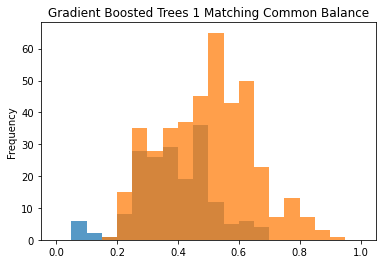

In [47]:
GBT_sr = pd.Series(trees_propensity).rename("propensity", inplace=True)
df_GBT = cleaned_df.join(GBT_sr)
matches_GBT = matching(label=treatment,
                       propensity=GBT_sr,
                       calipher=0.1,
                       replace=True)
matches_data_frame_GBT = matching_to_dataframe(match=matches_GBT,
                                               covariates=df_GBT,
                                               remove_duplicates=False)

matches_data_frame_GBT.groupby("T")["propensity"]\
    .plot(kind="hist",
          sharex=True,
          range=(0, 1),
          bins=20,
          alpha=0.75,
          title="Gradient Boosted Trees 1 Matching Common Balance")

In [48]:
GBT_balance_table, GBT_chi = print_balance_table(matches_data_frame_GBT)
GBT_balance_table

value                     
T                           0             1       
variable                    %    No.      %    No.
school     GP          100.00  182.0  73.77  301.0
           MS             NaN    NaN  26.23  107.0
sex        F            75.27  137.0  43.14  176.0
           M            24.73   45.0  56.86  232.0
address    R            19.78   36.0  33.09  135.0
           U            80.22  146.0  66.91  273.0
famsize    GT3          76.37  139.0  64.95  265.0
           LE3          23.63   43.0  35.05  143.0
Pstatus    A            15.93   29.0  10.05   41.0
           T            84.07  153.0  89.95  367.0
Mjob       at_home      14.29   26.0  17.65   72.0
           health        4.40    8.0   7.84   32.0
           other        44.51   81.0  38.97  159.0
           services     20.88   38.0  24.75  101.0
           teacher      15.93   29.0  10.78   44.0
Fjob       at_home       2.20    4.0   4.90   20.0
           health        7.14   13.0   1.96    8.0
           other        60.99  111.0  58.33  238.0
           services     15.38   28.0  32.11  131.0
           teacher      14.29   26.0   2.70   11.0
reason     course       39.01   71.0  41.67  170.0
           home         27.47   50.0  24.26   99.0
           other         7.14   13.0  12.75   52.0
           reputation   26.37   48.0  21.32   87.0
guardian   father       22.53   41.0  26.23  107.0
           mother       61.54  112.0  65.69  268.0
           other        15.93   29.0   8.09   33.0
schoolsup  no           87.36  159.0  89.95  367.0
           yes          12.64   23.0  10.05   41.0
famsup     no           34.62   63.0  43.87  179.0
           yes          65.38  119.0  56.13  229.0
paid       no           75.82  138.0  78.43  320.0
           yes          24.18   44.0  21.57   88.0
activities no           58.24  106.0  51.72  211.0
           yes          41.76   76.0  48.28  197.0
nursery    no           30.22   55.0  25.49  104.0
           yes          69.78  127.0  74.51  304.0
higher     no            4.95    9.0  12.75   52.0
           yes          95.05  173.0  87.25  356.0
internet   no           15.93   29.0  19.85   81.0
           yes          84.07  153.0  80.15  327.0
romantic   no           56.04  102.0  64.95  265.0
           yes          43.96   80.0  35.05  143.0

In [49]:
GBT_chi

,,Chi Square,p value
school,school,NaN,<0.05
sex,sex,50.91,<0.05
address,address,10.19,<0.05
famsize,famsize,7.09,<0.05
Pstatus,Pstatus,3.62,0.057
Mjob,Mjob,7.51,0.111
Fjob,Fjob,51.93,<0.05
reason,reason,5.72,0.126
guardian,guardian,8.39,<0.05
schoolsup,schoolsup,0.62,0.429


In [50]:
GBT_ATE = calc_ATE(matches_data_frame_GBT)
GBT_CI = calc_bootstap_CI(matches_data_frame_GBT)

$\hat (ATE) $=-1.04

**The CI for delta is:**

[-1.814424120001494, -0.29653654125879747]


In [51]:
res_dict['Gradient Boosted Trees Matching 1'] = [GBT_ATE, GBT_CI]

T
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

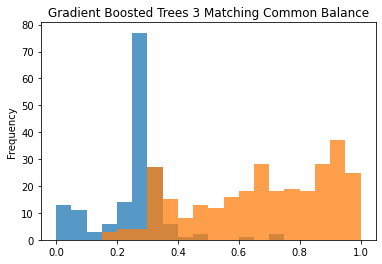

In [52]:
GBT3_sr = pd.Series(trees_propensity_3).rename("propensity", inplace=True)
df_GBT3 = cleaned_df.join(GBT3_sr)
matches_GBT3 = matching(label=treatment,
                        propensity=GBT3_sr,
                        calipher=0.1,
                        replace=True)
matches_data_frame_GBT3 = matching_to_dataframe(match=matches_GBT3,
                                                covariates=df_GBT3,
                                                remove_duplicates=False)

matches_data_frame_GBT3.groupby("T")["propensity"].plot(kind="hist",
                                                        sharex=True,
                                                        range=(0, 1),
                                                        bins=20,
                                                        alpha=0.75,
                                                        title="Gradient Boosted Trees 3 Matching Common Balance")

In [53]:
GBT3_balance_table, GBT3_chi = print_balance_table(matches_data_frame_GBT)
GBT3_balance_table

value                     
T                           0             1       
variable                    %    No.      %    No.
school     GP          100.00  182.0  73.77  301.0
           MS             NaN    NaN  26.23  107.0
sex        F            75.27  137.0  43.14  176.0
           M            24.73   45.0  56.86  232.0
address    R            19.78   36.0  33.09  135.0
           U            80.22  146.0  66.91  273.0
famsize    GT3          76.37  139.0  64.95  265.0
           LE3          23.63   43.0  35.05  143.0
Pstatus    A            15.93   29.0  10.05   41.0
           T            84.07  153.0  89.95  367.0
Mjob       at_home      14.29   26.0  17.65   72.0
           health        4.40    8.0   7.84   32.0
           other        44.51   81.0  38.97  159.0
           services     20.88   38.0  24.75  101.0
           teacher      15.93   29.0  10.78   44.0
Fjob       at_home       2.20    4.0   4.90   20.0
           health        7.14   13.0   1.96    8.0
           other        60.99  111.0  58.33  238.0
           services     15.38   28.0  32.11  131.0
           teacher      14.29   26.0   2.70   11.0
reason     course       39.01   71.0  41.67  170.0
           home         27.47   50.0  24.26   99.0
           other         7.14   13.0  12.75   52.0
           reputation   26.37   48.0  21.32   87.0
guardian   father       22.53   41.0  26.23  107.0
           mother       61.54  112.0  65.69  268.0
           other        15.93   29.0   8.09   33.0
schoolsup  no           87.36  159.0  89.95  367.0
           yes          12.64   23.0  10.05   41.0
famsup     no           34.62   63.0  43.87  179.0
           yes          65.38  119.0  56.13  229.0
paid       no           75.82  138.0  78.43  320.0
           yes          24.18   44.0  21.57   88.0
activities no           58.24  106.0  51.72  211.0
           yes          41.76   76.0  48.28  197.0
nursery    no           30.22   55.0  25.49  104.0
           yes          69.78  127.0  74.51  304.0
higher     no            4.95    9.0  12.75   52.0
           yes          95.05  173.0  87.25  356.0
internet   no           15.93   29.0  19.85   81.0
           yes          84.07  153.0  80.15  327.0
romantic   no           56.04  102.0  64.95  265.0
           yes          43.96   80.0  35.05  143.0

In [54]:
GBT3_chi

,,Chi Square,p value
school,school,NaN,<0.05
sex,sex,50.91,<0.05
address,address,10.19,<0.05
famsize,famsize,7.09,<0.05
Pstatus,Pstatus,3.62,0.057
Mjob,Mjob,7.51,0.111
Fjob,Fjob,51.93,<0.05
reason,reason,5.72,0.126
guardian,guardian,8.39,<0.05
schoolsup,schoolsup,0.62,0.429


In [55]:
GBT3_ATE = calc_ATE(matches_data_frame_GBT3)
GBT3_CI = calc_bootstap_CI(matches_data_frame_GBT3)

$\hat (ATE) $=-0.413

**The CI for delta is:**

[-1.038095238095238, 0.3003663003662975]


In [56]:
res_dict['Gradient Boosted Trees Matching 3'] = [GBT3_ATE, GBT3_CI]

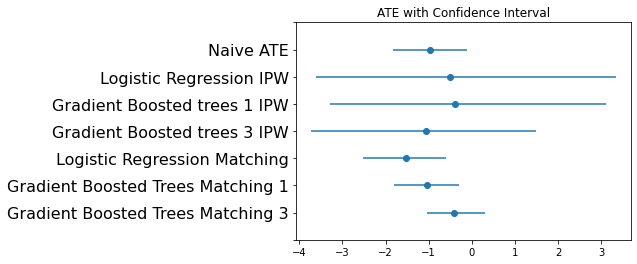

In [57]:
x = []
errors = []
est = []
y = [7, 6, 5, 4, 3, 2, 1]

for key, val in res_dict.items():
    x.append(np.mean(val[1]))
    errors.append((val[1][1]-val[1][0])/2)
    est.append(val[0])

plt.errorbar(x, y, xerr=errors, linestyle = 'None')
plt.scatter(est,y)
plt.yticks((0, 1, 2, 3, 4, 5, 6,7,8), ('', *(reversed(list(res_dict.keys()))),''),fontsize=16)
plt.title('ATE with Confidence Interval')
plt.savefig("ATEs.png")
plt.show()

In [58]:
res_dict_mod = {}
for key, value in res_dict.items():
    res_dict_mod[key] = [value[0]] + value[1]
res_pd = pd.DataFrame.from_dict(res_dict_mod).T
res_pd

,0,1,2
Naive ATE,-0.961712,-1.836567,-0.120626
Logistic Regression IPW,-0.511895,-3.608428,3.334819
Gradient Boosted trees 1 IPW,-0.392123,-3.296500,3.117658
Gradient Boosted trees 3 IPW,-1.052834,-3.726564,1.486288
Logistic Regression Matching,-1.537866,-2.514570,-0.591666
Gradient Boosted Trees Matching 1,-1.039557,-1.814424,-0.296537
Gradient Boosted Trees Matching 3,-0.412823,-1.038095,0.300366
